In [51]:
#Importing Library

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [52]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.float()
        h1 = F.relu(self.fc1(x.view(-1, 784)))
        h2 = F.relu(self.fc2(h1))
        h3 = F.relu(self.fc3(h2))
        h4 = F.relu(self.fc4(h3))
        h5 = F.relu(self.fc5(h4))
        h6 = self.fc6(h5)
        return F.softmax(h6, dim=1)

In [53]:
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # 첫번째층
        # ImgIn shape=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 두번째층
        # ImgIn shape=(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))

        # 전결합층 7x7x64 inputs -> 10 outputs
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

        # 전결합층 한정으로 가중치 초기화
        torch.nn.init.xavier_uniform_(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
        out = self.fc(out)
        return F.softmax(out, dim=1)

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net().to(device)
#model = CNN().to(device)
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=10, bias=True)
)


In [55]:
transform = transforms.Compose([
                 transforms.ToTensor(),
                 transforms.Normalize((0.1307,), (0.3081,))])

train_loader = torch.utils.data.DataLoader(
  datasets.MNIST('../data', train=True, download=True,
                 transform=transform),
    batch_size = 64, shuffle=True, )

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True,
                 transform=transform),
    batch_size=64, shuffle=True, )

In [56]:
epochs = 10
lr = 0.001
momentum = 0.5
no_cuda = True
seed = 1
log_interval = 200

torch.manual_seed(seed)
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [57]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [58]:
def test(log_interval, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format
          (test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [59]:
# Train and Test the model and save it.
for epoch in range(1, 11):
    train(log_interval, model, device, train_loader, optimizer, epoch)
    test(log_interval, model, device, test_loader)
torch.save(model, './model.pt')

Train Epoch: 1 [0/60000 (0%)]	Loss: -0.099125
Train Epoch: 1 [12800/60000 (21%)]	Loss: -0.585304
Train Epoch: 1 [25600/60000 (43%)]	Loss: -0.659596
Train Epoch: 1 [38400/60000 (64%)]	Loss: -0.646415
Train Epoch: 1 [51200/60000 (85%)]	Loss: -0.805050

Test set: Average loss: -0.8385, Accuracy: 8394/10000 (84%)

Train Epoch: 2 [0/60000 (0%)]	Loss: -0.785695
Train Epoch: 2 [12800/60000 (21%)]	Loss: -0.726755
Train Epoch: 2 [25600/60000 (43%)]	Loss: -0.820527
Train Epoch: 2 [38400/60000 (64%)]	Loss: -0.751455
Train Epoch: 2 [51200/60000 (85%)]	Loss: -0.827878

Test set: Average loss: -0.8495, Accuracy: 8500/10000 (85%)

Train Epoch: 3 [0/60000 (0%)]	Loss: -0.760508
Train Epoch: 3 [12800/60000 (21%)]	Loss: -0.900066
Train Epoch: 3 [25600/60000 (43%)]	Loss: -0.843730
Train Epoch: 3 [38400/60000 (64%)]	Loss: -0.796939
Train Epoch: 3 [51200/60000 (85%)]	Loss: -0.832635

Test set: Average loss: -0.8505, Accuracy: 8511/10000 (85%)

Train Epoch: 4 [0/60000 (0%)]	Loss: -0.867294
Train Epoch: 4 [12

In [60]:
mnist_test = datasets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

Label:  6
Prediction:  6


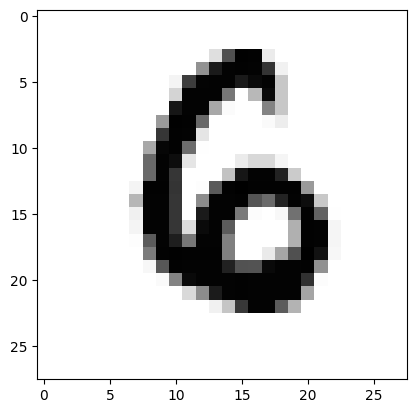

Label:  7
Prediction:  7


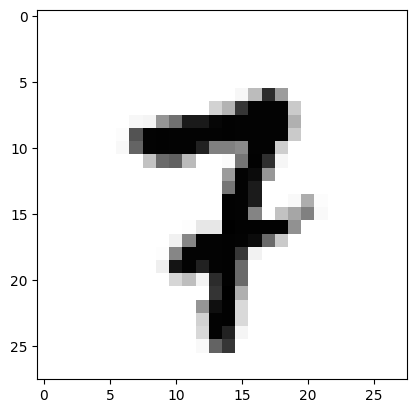

Label:  9
Prediction:  9


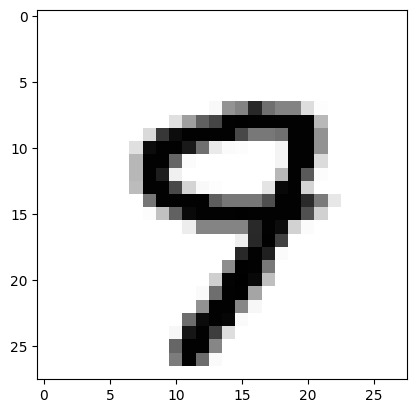

Label:  8
Prediction:  8


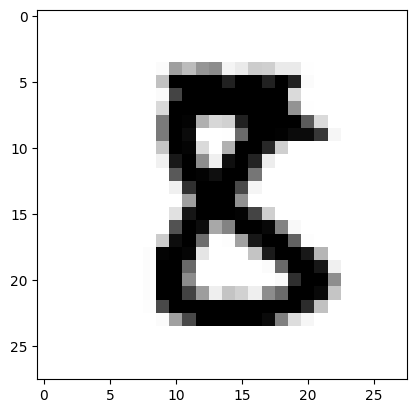

Label:  5
Prediction:  5


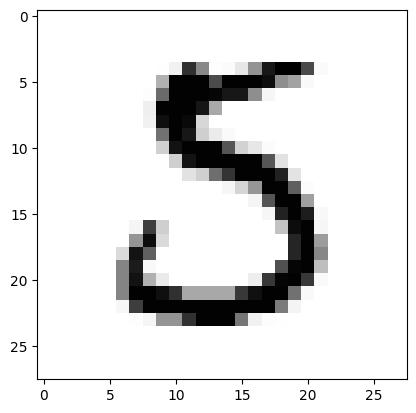

In [61]:
import matplotlib.pyplot as plt
import random

with torch.no_grad(): # torch.no_grad()를 하면 gradient 계산을 수행하지 않는다.
    for _ in range(5):
      r = random.randint(0, len(mnist_test) - 1)
      #X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
      X_single_data = mnist_test.test_data[r:r + 1].view(-1, 1, 28, 28).float().to(device)
      Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

      print('Label: ', Y_single_data.item())
      single_prediction = model(X_single_data)
      print('Prediction: ', torch.argmax(single_prediction, 1).item())

      plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
      plt.show()